# Topic to be determined

The analysis of the olympic games and athlete data is going to be done the following way:

1. PySpark **environment setup**
2. Data source and **Spark data abstraction** (DataFrame) **set up**
3. Data set **metadata analysis**:
  1. Display **schema and size** of the DataFrame
  2. Get one or multiple **random samples** from the data set to better understand what the data is all about
  3. Identify **data entities**, **metrics** and **dimensions**
4. Columns groups **basic profiling** to better understand our data set:

  1. **Human attributes related** columns basic profiling
  2. **Time / Games / Location related** columns basic profiling
  3. **Performance related** columns basic profiling
5. **Answer some questions about olympic performance** to enable athletes and coaches to better understand future performance
  1. **Top 20 most successful olympic athletes** in terms of medals won
  2. **Top 20 countries with the most medals won** absolute and relative against number of athletes
  3. **Exploring physical attributes of winning athletes** how do they compare against other athletes in their sports?

Let's go for it:

## 1. PySpark environment setup

In [6]:
import findspark
findspark.init()

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

## 2. Data source and Spark data abstraction (DataFrame) setup

The dataset used for the analysis can be found and downloaded here: https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results

In [7]:
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType

olympicSchema = StructType(\
                          [StructField("ID",IntegerType(),True),\
                           StructField("Name",StringType(),True),\
                           StructField("Sex",StringType(),True),\
                           StructField("Age",IntegerType(),True),\
                           StructField("Height",IntegerType(),True),\
                           StructField("Weight",IntegerType(),True),\
                           StructField("Team",StringType(),True),\
                           StructField("NOC",StringType(),True),\
                           StructField("Games",StringType(),True),\
                           StructField("Year",StringType(),True),\
                           StructField("Season",StringType(),True),\
                           StructField("City",StringType(),True),\
                           StructField("Sport",StringType(),True),\
                           StructField("Event",StringType(),True),\
                           StructField("Medal",StringType(),True)])
olympicDF = spark.read.schema(olympicSchema).option("header", "true").option("sep", ",").option("multiLine", "true").option("escape", "\"").csv("athlete_events.csv")

## 3. Data set metadata analysis
### A. Display schema and size of the DataFrame

In [8]:
from IPython.display import display, Markdown

olympicDF.printSchema()
display(Markdown("This DataFrame has **%d rows**." % olympicDF.count()))

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Height: integer (nullable = true)
 |-- Weight: integer (nullable = true)
 |-- Team: string (nullable = true)
 |-- NOC: string (nullable = true)
 |-- Games: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Sport: string (nullable = true)
 |-- Event: string (nullable = true)
 |-- Medal: string (nullable = true)



This DataFrame has **271116 rows**.

### B. Get one or multiple random samples from the data set

In [9]:
olympicDF.cache() # optimization to make the processing faster
olympicDF.sample(False, 0.1).take(2)

[Row(ID=2, Name='A Lamusi', Sex='M', Age=23, Height=170, Weight=60, Team='China', NOC='CHN', Games='2012 Summer', Year='2012', Season='Summer', City='London', Sport='Judo', Event="Judo Men's Extra-Lightweight", Medal='NA'),
 Row(ID=5, Name='Christine Jacoba Aaftink', Sex='F', Age=21, Height=185, Weight=82, Team='Netherlands', NOC='NED', Games='1988 Winter', Year='1988', Season='Winter', City='Calgary', Sport='Speed Skating', Event="Speed Skating Women's 1,000 metres", Medal='NA')]

We identified the following variables / columns:

    ID - Unique number for each athlete;
    Name - Athlete's name;
    Sex - M or F;
    Age - Integer;
    Height - In centimeters;
    Weight - In kilograms;
    Team - Team name;
    NOC - National Olympic Committee 3-letter code;
    Games - Year and season;
    Year - Integer;
    Season - Summer or Winter;
    City - Host city;
    Sport - Sport;
    Event - Event;
    Medal - Gold, Silver, Bronze, or NA.

### C. Data entities, metrics and dimensions

The following elements were identified:

* **Entities:** ID, Name 
* **Metrics:** Age, Height, Weight, Medal
* **Dimensions:** Sex, Team, NOC, Games, Year, Season, City, Sport, Event

### D. Column categorization

The following could be a potential column categorization:

* **Human attributes related columns:** *Sex*, *Age*, *Height*, *Weight*
* **Time / Games / Location columns:** *Team*, *NOC*, *Games*, *Year*, *Season*, *City*, *Sport*, *Event*
* **Performance related columns:** *Medal*

## 4. Column groups basic profiling to better understand our data set
### A. Human attributes columns basic profiling

In [55]:
from IPython.display import display, Markdown
from pyspark.sql.functions import when, count, col, countDistinct, desc, first, lit, mean, min, max, avg, countDistinct, round

display(Markdown("**Summary** of columns **Sex**, **Age**, **Height** and **Weight**:"))
olympicDF.select("Sex","Age","Height","Weight").summary().show()

display(Markdown("Checking for **nulls** in all columns:"))
olympicDF.select([count(when(col(c).isNull(), c)).alias(c) for c in ["ID", "Name","Sex","Age","Height","Weight","Team", "NOC", "Games", "Year", "Season", "City", "Sport", "Event", "Medal"]]).show()

display(Markdown("Checking amount of **distinct values** in columns **Age**, **Height** and **Weight**:"))
olympicDF.select([countDistinct(c).alias(c) for c in ["Age","Height","Weight"]]).show()

**Summary** of columns **Sex**, **Age**, **Height** and **Weight**:

+-------+------+------------------+------------------+------------------+
|summary|   Sex|               Age|            Height|            Weight|
+-------+------+------------------+------------------+------------------+
|  count|271116|            261642|            210945|            207183|
|   mean|  null|25.556898357297374|175.33896987366376| 70.68149413803256|
| stddev|  null| 6.393560847035836|10.518462222679204|14.329645879565714|
|    min|     F|                10|               127|                25|
|    25%|  null|                21|               168|                60|
|    50%|  null|                24|               175|                70|
|    75%|  null|                28|               183|                79|
|    max|     M|                97|               226|               214|
+-------+------+------------------+------------------+------------------+



Checking for **nulls** in all columns:

+---+----+---+----+------+------+----+---+-----+----+------+----+-----+-----+-----+
| ID|Name|Sex| Age|Height|Weight|Team|NOC|Games|Year|Season|City|Sport|Event|Medal|
+---+----+---+----+------+------+----+---+-----+----+------+----+-----+-----+-----+
|  0|   0|  0|9474| 60171| 63933|   0|  0|    0|   0|     0|   0|    0|    0|    0|
+---+----+---+----+------+------+----+---+-----+----+------+----+-----+-----+-----+



Checking amount of **distinct values** in columns **Age**, **Height** and **Weight**:

+---+------+------+
|Age|Height|Weight|
+---+------+------+
| 74|    95|   142|
+---+------+------+



In [30]:
pip install pyspark-dist-explore

Note: you may need to restart the kernel to use updated packages.


In [52]:
#replace null values in the df with mean value
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCols=["Age","Height","Weight"], outputCols=["Age1","Height1","Weight1"])
model = imputer.fit(olympicDF)

olympicDF = model.transform(olympicDF)

In [56]:
#check
display(Markdown("Checking for **nulls** in all columns:"))
olympicDF.select([count(when(col(c).isNull(), c)).alias(c) for c in ["Sex","Age1","Height1","Weight1","ID", "Name","Team", "NOC", "Games", "Year", "Season", "City", "Sport", "Event", "Medal"]]).show()

Checking for **nulls** in all columns:

+---+----+-------+-------+---+----+----+---+-----+----+------+----+-----+-----+-----+
|Sex|Age1|Height1|Weight1| ID|Name|Team|NOC|Games|Year|Season|City|Sport|Event|Medal|
+---+----+-------+-------+---+----+----+---+-----+----+------+----+-----+-----+-----+
|  0|   0|      0|      0|  0|   0|   0|  0|    0|   0|     0|   0|    0|    0|    0|
+---+----+-------+-------+---+----+----+---+-----+----+------+----+-----+-----+-----+



array([[<AxesSubplot:title={'center':'Height'}>]], dtype=object)

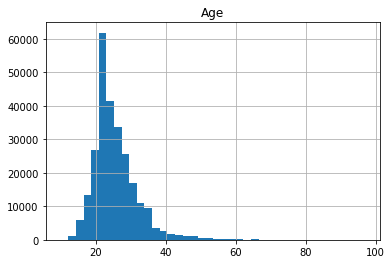

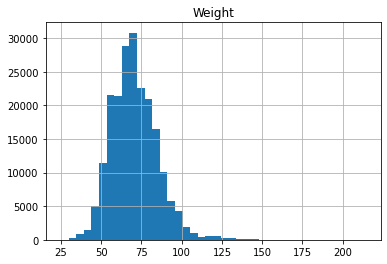

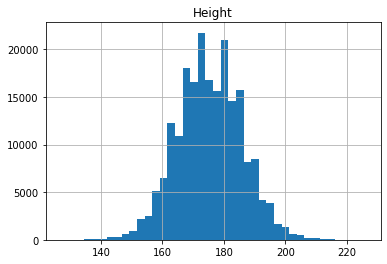

In [62]:
#display histograms for numeric columns (let's disregard the imputed missing values for now)
import pandas as pd
olympic_viz = olympicDF.toPandas()
olympic_viz.hist("Age", bins = 40)
olympic_viz.hist("Weight", bins = 40)
olympic_viz.hist("Height", bins = 40)

In [33]:
display(Markdown("Min, max and average values for **Age**, **Height** and **Weight** columns per sport:"))
olympicDF.groupBy("Sport")\
    .agg(min("Age1").alias("min_Age"),\
         round(avg("Age1"),2).alias("avg_Age"),
         max("Age1").alias("max_Age"),
         min("Height1").alias("min_Height"),
         round(avg("Height1"),2).alias("avg_Height"),
         max("Height1").alias("max_Height"),
         min("Weight1").alias("min_Weight"),
         round(avg("Weight1"),2).alias("avg_Weight"),
         max("Weight1").alias("max_Weight"))\
     .show(200,False)

Min, max and average values for **Age**, **Height** and **Weight** columns per sport:

+-------------------------+-------+-------+-------+----------+----------+----------+----------+----------+----------+
|Sport                    |min_Age|avg_Age|max_Age|min_Height|avg_Height|max_Height|min_Weight|avg_Weight|max_Weight|
+-------------------------+-------+-------+-------+----------+----------+----------+----------+----------+----------+
|Gymnastics               |10     |22.83  |49     |127       |166.57    |188       |25        |61.04     |102       |
|Tennis                   |13     |25.81  |47     |150       |177.78    |208       |48        |70.56     |111       |
|Boxing                   |15     |23.16  |41     |127       |173.35    |208       |46        |66.42     |140       |
|Ice Hockey               |15     |25.83  |48     |150       |178.26    |206       |47        |78.83     |116       |
|Golf                     |15     |29.19  |50     |157       |174.62    |196       |48        |70.52     |104       |
|Rowing                   |11     |25.26  |60     |132  

In [34]:
display(Markdown("Most and least frequent occurrences for **Age**, **Height** and **Weight** columns:"))
AgeOccurrencesDF = olympicDF.groupBy("Age1").agg(count(lit(1)).alias("Total"))
HeightOccurencesDF = olympicDF.groupBy("Height1").agg(count(lit(1)).alias("Total"))
WeightOccurencesDF = olympicDF.groupBy("Weight1").agg(count(lit(1)).alias("Total"))

leastFreqAge    = AgeOccurrencesDF.orderBy(col("Total").asc()).first()
mostFreqAge     = AgeOccurrencesDF.orderBy(col("Total").desc()).first()
leastFreqHeight    = HeightOccurencesDF.orderBy(col("Total").asc()).first()
mostFreqHeight      = HeightOccurencesDF.orderBy(col("Total").desc()).first()
leastFreqWeight    = WeightOccurencesDF.orderBy(col("Total").asc()).first()
mostFreqWeight      = WeightOccurencesDF.orderBy(col("Total").desc()).first()

display(Markdown("""
| %s | %s | %s | %s |
|----|----|----|----|
| %s | %s | %s | %s |
""" % ("leastFreqAge", "mostFreqAge", "leastFreqHeight", "mostFreqHeight", \
       "%s (%d occurrences)" % (leastFreqAge["Age1"], leastFreqAge["Total"]), \
       "%s (%d occurrences)" % (mostFreqAge["Age1"], mostFreqAge["Total"]), \
       "%s (%d occurrences)" % (leastFreqHeight["Height1"], leastFreqHeight["Total"]), \
       "%s (%d occurrences)" % (mostFreqHeight["Height1"], mostFreqHeight["Total"]))))

display(Markdown("""
| %s | %s |
|----|----|
| %s | %s | 
""" % ("leastFreqWeight", "mostFreqWeight", \
       "%s (%d occurrences)" % (leastFreqWeight["Weight1"], leastFreqWeight["Total"]),\
       "%s (%d occurrences)" % (mostFreqWeight["Weight1"], mostFreqWeight["Total"]))))

Most and least frequent occurrences for **Age**, **Height** and **Weight** columns:


| leastFreqAge | mostFreqAge | leastFreqHeight | mostFreqHeight |
|----|----|----|----|
| 96 (1 occurrences) | 25 (29181 occurrences) | 128 (1 occurrences) | 175 (70491 occurrences) |



| leastFreqWeight | mostFreqWeight |
|----|----|
| 190 (1 occurrences) | 70 (73558 occurrences) | 


### B. Time / Games / Location columns basic profiling

In [66]:
#Team, NOC, Games, Year, Season, City, Sport, Event

display(Markdown("Summary of columns **Team**, **NOC**, **Games**, **Year**:"))
olympicDF.select("Team", "NOC", "Games", "Year").summary().show()
display(Markdown("Summary of columns **Season**, **City**, **Sport**, **Event**:"))
olympicDF.select("Season", "City", "Sport", "Event").summary().show()

display(Markdown("Checking amount of distinct values in columns **Team**, **NOC**, **Games**, **Year**, **Season**, **City**, **Sport**, **Event**:"))
olympicDF.select([countDistinct(c).alias(c) for c in ["Team", "NOC", "Games", "Year", "Season", "City", "Sport", "Event"]]).show()

Summary of columns **Team**, **NOC**, **Games**, **Year**:

+-------+-----------+------+-----------+------------------+
|summary|       Team|   NOC|      Games|              Year|
+-------+-----------+------+-----------+------------------+
|  count|     271116|271116|     271116|            271116|
|   mean|       null|  null|       null|1978.3784800601957|
| stddev|       null|  null|       null|29.877631985613142|
|    min|30. Februar|   AFG|1896 Summer|              1896|
|    25%|       null|  null|       null|            1960.0|
|    50%|       null|  null|       null|            1988.0|
|    75%|       null|  null|       null|            2002.0|
|    max|       rn-2|   ZIM|2016 Summer|              2016|
+-------+-----------+------+-----------+------------------+



Summary of columns **Season**, **City**, **Sport**, **Event**:

+-------+------+-----------+-----------+--------------------+
|summary|Season|       City|      Sport|               Event|
+-------+------+-----------+-----------+--------------------+
|  count|271116|     271116|     271116|              271116|
|   mean|  null|       null|       null|                null|
| stddev|  null|       null|       null|                null|
|    min|Summer|Albertville|Aeronautics|Aeronautics Mixed...|
|    25%|  null|       null|       null|                null|
|    50%|  null|       null|       null|                null|
|    75%|  null|       null|       null|                null|
|    max|Winter|  Vancouver|  Wrestling|Wrestling Women's...|
+-------+------+-----------+-----------+--------------------+



Checking amount of distinct values in columns **Team**, **NOC**, **Games**, **Year**, **Season**, **City**, **Sport**, **Event**:

+----+---+-----+----+------+----+-----+-----+
|Team|NOC|Games|Year|Season|City|Sport|Event|
+----+---+-----+----+------+----+-----+-----+
|1184|230|   51|  35|     2|  42|   66|  765|
+----+---+-----+----+------+----+-----+-----+



In [38]:
display(Markdown("Most and least frequent occurrences for **Team**, **NOC**, **Games**, **Year**, **City**, **Sport**, **Event** columns:"))
TeamDF = olympicDF.groupBy("Team").agg(count(lit(1)).alias("Total"))
NOCDF   = olympicDF.groupBy("NOC").agg(count(lit(1)).alias("Total"))
GamesDF    = olympicDF.groupBy("Games").agg(count(lit(1)).alias("Total"))
YearDF      = olympicDF.groupBy("Year").agg(count(lit(1)).alias("Total"))
CityDF      = olympicDF.groupBy("City").agg(count(lit(1)).alias("Total"))
SportDF      = olympicDF.groupBy("Sport").agg(count(lit(1)).alias("Total"))
EventDF      = olympicDF.groupBy("Event").agg(count(lit(1)).alias("Total"))

leastFreqTeam = TeamDF.orderBy(col("Total").asc()).first()
mostFreqTeam = TeamDF.orderBy(col("Total").desc()).first()
leastFreqNOC = NOCDF.orderBy(col("Total").asc()).first()
mostFreqNOC = NOCDF.orderBy(col("Total").desc()).first()
leastFreqGames = GamesDF.orderBy(col("Total").asc()).first()
mostFreqGames = GamesDF.orderBy(col("Total").desc()).first()
leastFreqYear = YearDF.orderBy(col("Total").asc()).first()
mostFreqYear = YearDF.orderBy(col("Total").desc()).first()
leastFreqCity = CityDF.orderBy(col("Total").asc()).first()
mostFreqCity = CityDF.orderBy(col("Total").desc()).first()
leastFreqSport = SportDF.orderBy(col("Total").asc()).first()
mostFreqSport = SportDF.orderBy(col("Total").desc()).first()
leastFreqEvent = EventDF.orderBy(col("Total").asc()).first()
mostFreqEvent = EventDF.orderBy(col("Total").desc()).first()

display(Markdown("""
| %s | %s | %s | %s |
|----|----|----|----|
| %s | %s | %s | %s |
""" % ("leastFreqTeam", "mostFreqTeam", "leastFreqNOC", "mostFreqNOC", \
       "%s (%d occurrences)" % (leastFreqTeam["Team"], leastFreqTeam["Total"]), \
       "%s (%d occurrences)" % (mostFreqTeam["Team"], mostFreqTeam["Total"]), \
       "%s (%d occurrences)" % (leastFreqNOC["NOC"], leastFreqNOC["Total"]), \
       "%s (%d occurrences)" % (mostFreqNOC["NOC"], mostFreqNOC["Total"]))))

display(Markdown("""
| %s | %s | %s | %s |
|----|----|----|----|
| %s | %s | %s | %s |
""" % ("leastFreqGames", "mostFreqGames", "leastFreqYear", "mostFreqYear", \
       "%s (%d occurrences)" % (leastFreqGames["Games"], leastFreqGames["Total"]), \
       "%s (%d occurrences)" % (mostFreqGames["Games"], mostFreqGames["Total"]), \
       "%s (%d occurrences)" % (leastFreqYear["Year"], leastFreqYear["Total"]), \
       "%s (%d occurrences)" % (mostFreqYear["Year"], mostFreqYear["Total"]))))

display(Markdown("""
| %s | %s | %s | %s |
|----|----|----|----|
| %s | %s | %s | %s |
""" % ("leastFreqCity", "mostFreqCity", "leastFreqSport", "mostFreqSport", \
       "%s (%d occurrences)" % (leastFreqCity["City"], leastFreqCity["Total"]), \
       "%s (%d occurrences)" % (mostFreqCity["City"], mostFreqCity["Total"]), \
       "%s (%d occurrences)" % (leastFreqSport["Sport"], leastFreqSport["Total"]), \
       "%s (%d occurrences)" % (mostFreqSport["Sport"], mostFreqSport["Total"]))))

display(Markdown("""
| %s | %s |
|----|----|
| %s | %s | 
""" % ("leastFreqEvent", "mostFreqEvent", \
       "%s (%d occurrences)" % (leastFreqEvent["Event"], leastFreqEvent["Total"]),\
       "%s (%d occurrences)" % (mostFreqEvent["Event"], mostFreqEvent["Total"]))))

Most and least frequent occurrences for **Team**, **NOC**, **Games**, **Year**, **City**, **Sport**, **Event** columns:


| leastFreqTeam | mostFreqTeam | leastFreqNOC | mostFreqNOC |
|----|----|----|----|
| Mainz (1 occurrences) | United States (17847 occurrences) | NFL (1 occurrences) | USA (18853 occurrences) |



| leastFreqGames | mostFreqGames | leastFreqYear | mostFreqYear |
|----|----|----|----|
| 1932 Winter (352 occurrences) | 2000 Summer (13821 occurrences) | 1896 (380 occurrences) | 1992 (16413 occurrences) |



| leastFreqCity | mostFreqCity | leastFreqSport | mostFreqSport |
|----|----|----|----|
| Chamonix (460 occurrences) | London (22426 occurrences) | Aeronautics (1 occurrences) | Athletics (38624 occurrences) |



| leastFreqEvent | mostFreqEvent |
|----|----|
| Aeronautics Mixed Aeronautics (1 occurrences) | Football Men's Football (5733 occurrences) | 


### C. Performance columns basic profiling

In [39]:
display(Markdown("Summary of columns **Medal**:"))
olympicDF.select("Medal").summary().show()

display(Markdown("Checking amount of distinct values in columns **Medal**:"))
olympicDF.select([countDistinct(c).alias(c) for c in ["Medal"]]).show()

Summary of columns **Medal**:

+-------+------+
|summary| Medal|
+-------+------+
|  count|271116|
|   mean|  null|
| stddev|  null|
|    min|Bronze|
|    25%|  null|
|    50%|  null|
|    75%|  null|
|    max|Silver|
+-------+------+



Checking amount of distinct values in columns **Medal**:

+-----+
|Medal|
+-----+
|    4|
+-----+



In [70]:
display(Markdown("Most and least frequent occurrences for **Medal** column:"))
MedalDF = olympicDF.groupBy("Medal").agg(count(lit(1)).alias("Total"))

leastFreqMedal = MedalDF.orderBy(col("Total").asc()).first()
mostFreqMedal = MedalDF.orderBy(col("Total").desc()).first()

display(Markdown("""
| %s | %s |
|----|----|
| %s | %s | 
""" % ("leastFreqMedal", "mostFreqMedal", \
       "%s (%d occurrences)" % (leastFreqMedal["Medal"], leastFreqMedal["Total"]),\
       "%s (%d occurrences)" % (mostFreqMedal["Medal"], mostFreqMedal["Total"]))))

Most and least frequent occurrences for **Medal** column:


| leastFreqMedal | mostFreqMedal |
|----|----|
| Silver (13116 occurrences) | NA (231333 occurrences) | 


In [72]:
MedalDF.orderBy(col("Total").desc()).show()

+------+------+
| Medal| Total|
+------+------+
|    NA|231333|
|  Gold| 13372|
|Bronze| 13295|
|Silver| 13116|
+------+------+



## 5. Answering Questions about Olympic Performance

### A. Top 20 most successful olympic athletes in terms of medals won

In [41]:
# Checking who won the most medals including all levels (Gold, Silver and Bronze)

# 1. Let's enrich the df with additional columns to count the medals the athlete won
totalDF = olympicDF.count()
medalswonDF = olympicDF\
   .where(col("Medal")!="NA")\
.withColumn("Gold", when(col("Medal")== "Gold",("1")).cast("Integer"))\
.withColumn("Silver", when(col("Medal")== "Silver",("1")).cast("Integer"))\
.withColumn("Bronze", when(col("Medal")== "Bronze",("1")).cast("Integer"))\

#create df to count number of athletes
athleteDF = olympicDF\
.select(col("ID"),col("NOC"))\
.withColumn("Athlete Count", lit(1))

In [42]:
#let's see who is the most successful olympic athlete in terms of medals won
display(Markdown("**Top 20 most successful olympic athletes** with most medals won:"))
medalswonDF.where(col("Medal")!="NA")\
                 .select("Name", "Sport", "Gold", "Silver", "Bronze")\
                 .groupBy("Name", "Sport")\
                 .agg(count("Gold").alias("Gold Medals won"),
                      count("Silver").alias("Silver Medals won"),
                      count("Bronze").alias("Bronze Medals won")) \
                 .orderBy(col("Gold Medals won").desc(), col("Silver Medals won").desc(),\
                          col("Bronze Medals won").desc()).limit(20).show()

**Top 20 most successful olympic athletes** with most medals won:

+--------------------+-------------+---------------+-----------------+-----------------+
|                Name|        Sport|Gold Medals won|Silver Medals won|Bronze Medals won|
+--------------------+-------------+---------------+-----------------+-----------------+
|Michael Fred Phel...|     Swimming|             23|                3|                2|
|Raymond Clarence ...|    Athletics|             10|                0|                0|
|Larysa Semenivna ...|   Gymnastics|              9|                5|                4|
|Paavo Johannes Nurmi|    Athletics|              9|                3|                0|
|   Mark Andrew Spitz|     Swimming|              9|                1|                1|
|Frederick Carlton...|    Athletics|              9|                1|                0|
| Ole Einar Bjrndalen|     Biathlon|              8|                4|                1|
|Birgit Fischer-Sc...|     Canoeing|              8|                4|                0|
|          Sawao Kato

### B. Top 20 countries with the most medals won, absolute and relative against number of athletes

In [73]:
#add total medal column and replace null values
totalmedalDF = medalswonDF\
.withColumn("Gold", when (medalswonDF.Gold.isNull(),lit(0)).otherwise(medalswonDF.Gold))\
.withColumn("Silver", when (medalswonDF.Silver.isNull(),lit(0)).otherwise(medalswonDF.Silver))\
.withColumn("Bronze", when (medalswonDF.Bronze.isNull(),lit(0)).otherwise(medalswonDF.Bronze))\
.withColumn("Total Medal", col("Gold")+col("Silver")+col("Bronze"))\

#create two dfs to count total medals and participating athletes for the 15 most succerssful countries
medalDF = totalmedalDF\
.select("NOC", "Total Medal")\
.groupBy("NOC")\
.agg(count("Total Medal").alias("Total Medals won"))\
.orderBy(col("Total Medals won").desc()).limit(20)

athDF = athleteDF\
.select("NOC", "Athlete Count")\
.groupBy("NOC")\
.agg(count("Athlete Count").alias("Total Athletes"))\
.orderBy(col("Total Athletes").desc()).limit(20)

In [74]:
#combine dataframes
combinedDF = \
medalDF\
.join(athDF, "NOC")\
.withColumn("winningRatio", round(col("Total Medals Won")/col("Total Athletes")*100,2))\
.orderBy(col("winningRatio").desc())
combinedDF.cache() #optimize to speed up processing

display(Markdown("**Top 20 countries with most medals won** as ratio in athletes participating:"))
combinedDF\
.select("NOC", "Total Medals won", "Total Athletes", "winningRatio").show()

**Top 20 countries with most medals won** as ratio in athletes participating:

+---+----------------+--------------+------------+
|NOC|Total Medals won|Total Athletes|winningRatio|
+---+----------------+--------------+------------+
|URS|            2503|          5685|       44.03|
|USA|            5637|         18853|        29.9|
|RUS|            1165|          5143|       22.65|
|GER|            2165|          9830|       22.02|
|NOR|            1033|          4960|       20.83|
|CHN|             989|          5141|       19.24|
|SWE|            1536|          8339|       18.42|
|NED|            1040|          5839|       17.81|
|AUS|            1320|          7638|       17.28|
|HUN|            1135|          6607|       17.18|
|GBR|            2068|         12256|       16.87|
|FIN|             900|          5467|       16.46|
|ITA|            1637|         10715|       15.28|
|FRA|            1777|         12758|       13.93|
|CAN|            1352|          9733|       13.89|
|SUI|             691|          6150|       11.24|
|JPN|             913|         

### C. Exploring physical attributes of winning athletes, how do they compare against other athletes in their sports?


In [45]:
#let's see which athlets (from which sports) won the most medals
totalmedalDF\
.select("Name", "Sport", "Total Medal")\
.groupBy("Name", "Sport")\
.agg(count("Total Medal").alias("Total Medals won"))\
.orderBy(col("Total Medals won").desc()).limit(20).show()

+--------------------+----------+----------------+
|                Name|     Sport|Total Medals won|
+--------------------+----------+----------------+
|Michael Fred Phel...|  Swimming|              28|
|Larysa Semenivna ...|Gymnastics|              18|
|Nikolay Yefimovic...|Gymnastics|              15|
| Edoardo Mangiarotti|   Fencing|              13|
| Ole Einar Bjrndalen|  Biathlon|              13|
|Borys Anfiyanovyc...|Gymnastics|              13|
|         Takashi Ono|Gymnastics|              13|
|  Ryan Steven Lochte|  Swimming|              12|
|Paavo Johannes Nurmi| Athletics|              12|
|Natalie Anne Coug...|  Swimming|              12|
|Aleksey Yuryevich...|Gymnastics|              12|
|Birgit Fischer-Sc...|  Canoeing|              12|
|          Sawao Kato|Gymnastics|              12|
|Dara Grace Torres...|  Swimming|              12|
|Jennifer Elisabet...|  Swimming|              12|
|Viktor Ivanovych ...|Gymnastics|              11|
|Carl Townsend Osburn|  Shootin

In [46]:
#let's have a look at the predominant physical attributes in Gwimming, Gymnastics and Fencing
#and how the top three athletes in these sports compare to those numbers

display(Markdown("Summary of physical attributes in **Swimming**:"))
olympicDF\
.where(col("Sport") == "Swimming")\
.select(col("Age1").alias("Age"),col("Height1").alias("Height"),col("Weight1").alias("Weight"))\
.summary().show()

display(Markdown("Summary of physical attributes of **Michael Phelps**:"))
olympicDF\
.where(col("Name") == "Michael Fred Phelps, II")\
.select(col("Age1").alias("Age"),col("Height1").alias("Height"),col("Weight1").alias("Weight"))\
.summary().show()

display(Markdown("In terms of Height and Weight he is definitly **heavier** and **taller** than\
 the average swimming athlete!"))

Summary of physical attributes in **Swimming**:

+-------+------------------+------------------+------------------+
|summary|               Age|            Height|            Weight|
+-------+------------------+------------------+------------------+
|  count|             23195|             23195|             23195|
|   mean|20.666954084932097|177.94119422289288| 70.47928432851907|
| stddev|3.7539563809696297|  9.09340403454148|10.196374847007569|
|    min|                11|               131|                39|
|    25%|                18|               173|                64|
|    50%|                20|               175|                70|
|    75%|                23|               184|                76|
|    max|                46|               209|               114|
+-------+------------------+------------------+------------------+



Summary of physical attributes of **Michael Phelps**:

+-------+-----------------+------+------+
|summary|              Age|Height|Weight|
+-------+-----------------+------+------+
|  count|               30|    30|    30|
|   mean|             24.2| 193.0|  91.0|
| stddev|4.715345454854894|   0.0|   0.0|
|    min|               15|   193|    91|
|    25%|               19|   193|    91|
|    50%|               23|   193|    91|
|    75%|               27|   193|    91|
|    max|               31|   193|    91|
+-------+-----------------+------+------+



In terms of Height and Weight he is definitly **heavier** and **taller** than the average swimming athlete!

In [47]:
display(Markdown("Summary of physical attributes in **Gymnastics**:"))
olympicDF\
.where(col("Sport") == "Gymnastics")\
.select(col("Age1").alias("Age"),col("Height1").alias("Height"),col("Weight1").alias("Weight"))\
.summary().show()

display(Markdown("Summary of physical attributes of **Larysa Semenivna Latynina**:"))
olympicDF\
.where(col("Name") == "Larysa Semenivna Latynina (Diriy-)")\
.select(col("Age1").alias("Age"),col("Height1").alias("Height"),col("Weight1").alias("Weight"))\
.summary().show()

display(Markdown("Her weight is almost **10kg lower** than the average!"))

Summary of physical attributes in **Gymnastics**:

+-------+------------------+-----------------+------------------+
|summary|               Age|           Height|            Weight|
+-------+------------------+-----------------+------------------+
|  count|             26707|            26707|             26707|
|   mean|22.833114913693038|166.5700752611675| 61.04055116636088|
| stddev| 4.818052473787331|8.868721451303445|10.158290166095187|
|    min|                10|              127|                25|
|    25%|                19|              161|                54|
|    50%|                23|              168|                64|
|    75%|                25|              175|                70|
|    max|                49|              188|               102|
+-------+------------------+-----------------+------------------+



Summary of physical attributes of **Larysa Semenivna Latynina**:

+-------+------------------+------+------+
|summary|               Age|Height|Weight|
+-------+------------------+------+------+
|  count|                19|    19|    19|
|   mean|24.789473684210527| 161.0|  52.0|
| stddev|3.3924580955148986|   0.0|   0.0|
|    min|                21|   161|    52|
|    25%|                21|   161|    52|
|    50%|                25|   161|    52|
|    75%|                29|   161|    52|
|    max|                29|   161|    52|
+-------+------------------+------+------+



Her weight is almost **10kg lower** than the average!

In [48]:
display(Markdown("Summary of physical attributes in **Fencing**:"))
olympicDF\
.where(col("Sport") == "Fencing")\
.select(col("Age1").alias("Age"),col("Height1").alias("Height"),col("Weight1").alias("Weight"))\
.summary().show()

display(Markdown("Summary of physical attributes of **Edoardo Mangiarotti**:"))
olympicDF\
.where(col("Name") == "Edoardo Mangiarotti")\
.select(col("Age1").alias("Age"),col("Height1").alias("Height"),col("Weight1").alias("Weight"))\
.summary().show()

display(Markdown("He seems to be almost perfectly average when it comes to height and weight, his outstandig\
 olympic track record must be due to hist talent!"))

Summary of physical attributes in **Fencing**:

+-------+------------------+------------------+-----------------+
|summary|               Age|            Height|           Weight|
+-------+------------------+------------------+-----------------+
|  count|             10735|             10735|            10735|
|   mean|28.303120633442013|176.40353982300886|70.84685607824872|
| stddev|6.3770541757741235| 6.930514783721811| 7.82025237770739|
|    min|                14|               152|               44|
|    25%|                24|               175|               70|
|    50%|                27|               175|               70|
|    75%|                32|               180|               75|
|    max|                63|               208|              108|
+-------+------------------+------------------+-----------------+



Summary of physical attributes of **Edoardo Mangiarotti**:

+-------+------------------+------+------+
|summary|               Age|Height|Weight|
+-------+------------------+------+------+
|  count|                14|    14|    14|
|   mean|33.285714285714285| 175.0|  70.0|
| stddev| 6.169759644097496|   0.0|   0.0|
|    min|                17|   175|    70|
|    25%|                29|   175|    70|
|    50%|                33|   175|    70|
|    75%|                37|   175|    70|
|    max|                41|   175|    70|
+-------+------------------+------+------+



He seems to be almost perfectly average when it comes to height and weight, his outstandig olympic track record must be due to hist talent!